<a href="https://colab.research.google.com/github/SamuReyes/practica_final_IAO/blob/clasificador/notebook_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = "simonbermejomendez"
os.environ['KAGGLE_KEY'] = "cda106a2f3240f78cfd62bb0ec8d66c3"

In [ ]:
!kaggle datasets download -d mahmoudima/mma-facial-expression

In [ ]:
!unzip /content/mma-facial-expression.zip

In [ ]:
!pip install keras-tuner -q

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, \
Rescaling, Lambda, Dropout
from keras import optimizers
import keras_tuner as kt
import cv2
import matplotlib.pyplot as plt

In [7]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#Dataset 
- link: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 

In [21]:
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/MMAFEDB/train',
    #para obtenerlo en color: color_mode = "rgb"
    color_mode = 'grayscale',
    shuffle = True,
    batch_size = 32,
    image_size = (48,48),
    seed = 123
)

Found 92968 files belonging to 7 classes.


In [32]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/MMAFEDB/valid',
    #para obtenerlo en color: color_mode = "rgb"
    color_mode = 'grayscale',
    shuffle = True,
    batch_size = 32,
    image_size = (48,48),
    seed = 123
)

Found 17356 files belonging to 7 classes.


In [33]:
test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/MMAFEDB/test',
    #para obtenerlo en color: color_mode = "rgb"
    color_mode = 'grayscale',
    shuffle = True,
    batch_size = 32,
    image_size = (48,48),
    seed = 123
)

Found 17356 files belonging to 7 classes.


##Visualización de los datos

In [ ]:
cv2.imread('/content/MMAFEDB/test/angry/10Exp0angry_actor_150.jpg').shape

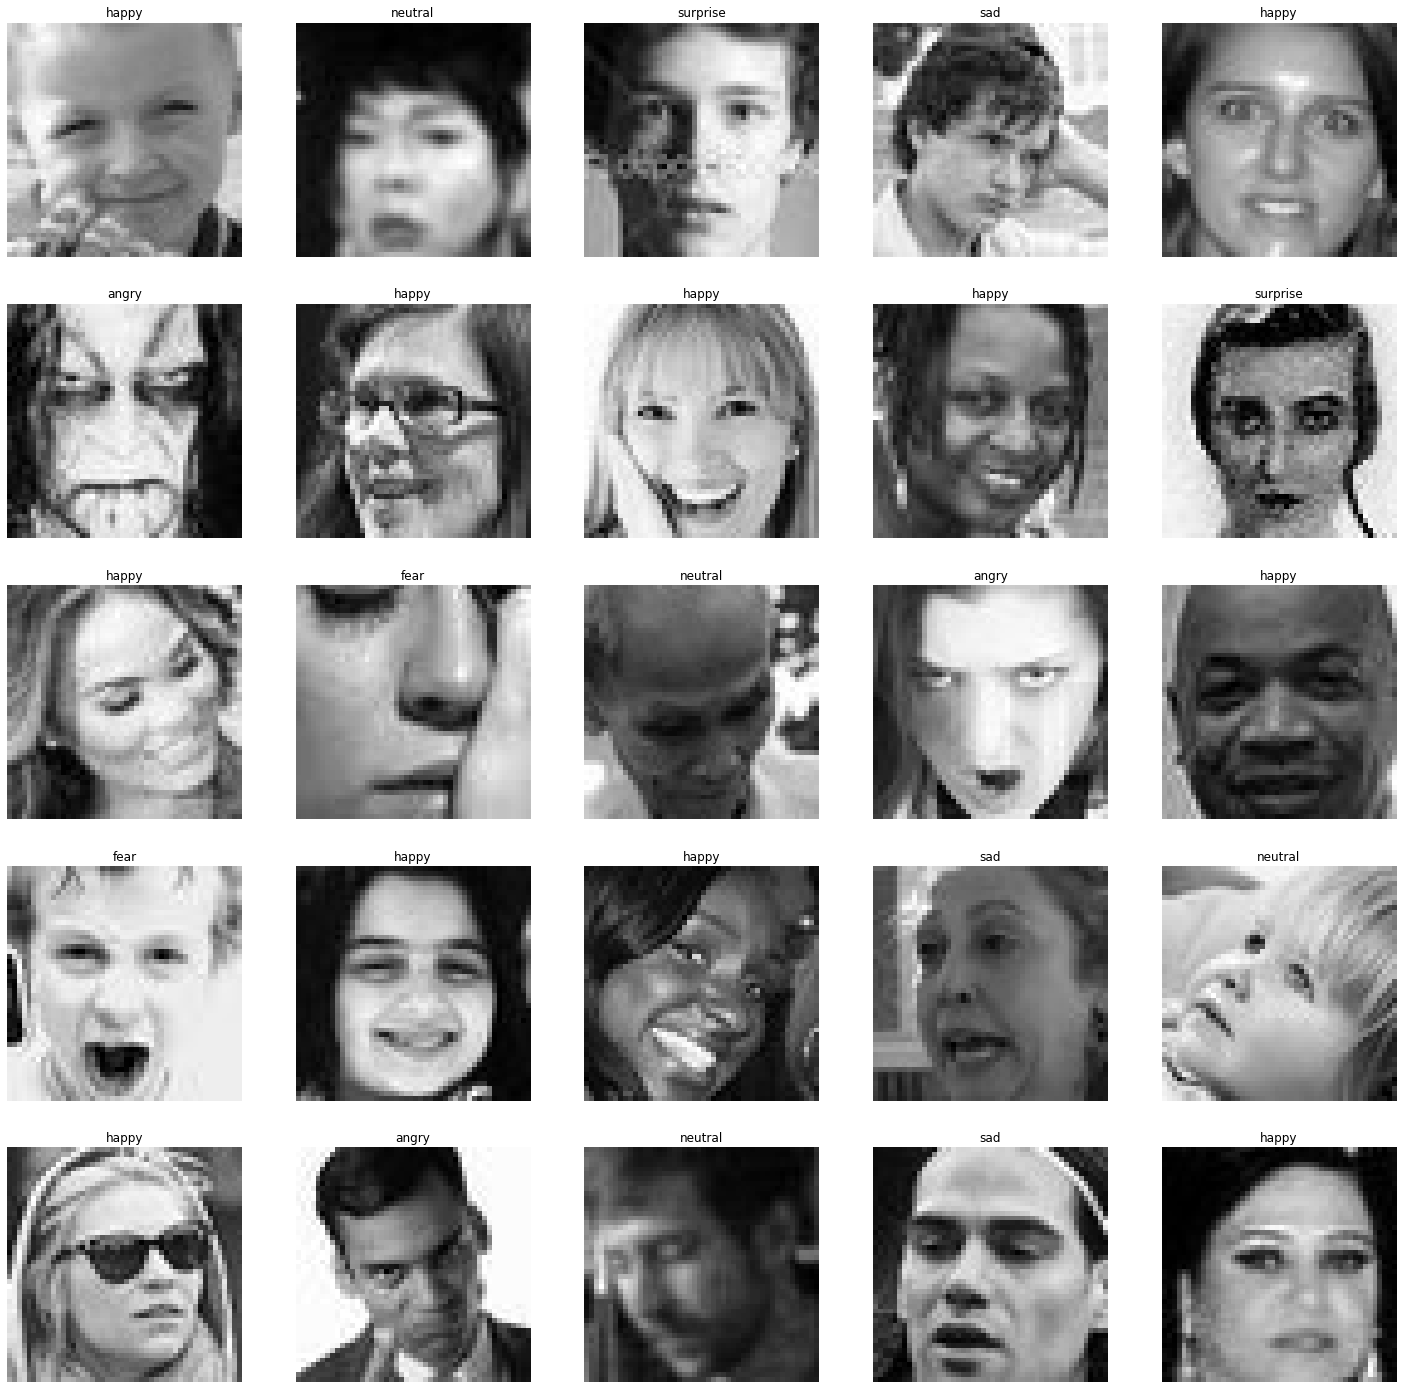

In [22]:
class_names = training_set.class_names

plt.figure(figsize=(25, 25))
for images, labels in training_set.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    #Para obtenerlo en color eliminar : .reshape(48,48), cmap="gray"
    plt.imshow(images[i].numpy().astype("uint8").reshape(48,48), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")


#Rendimientos de memoria
- Dataset.cache: mantiene en cache las imagenes.
- Dataset.prefetch: superpone / carga del cache.

In [23]:
#ni santa idea pero esto es para colab y la memoria :)
AUTOTUNE = tf.data.AUTOTUNE
#Guardamos en cache 1000 datos aleatorios. 
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#Ejemplo de modelo
- Para construir el modelo link: https://www.tensorflow.org/tutorials/images/classification




In [27]:
model = Sequential()
#Kernel_size => se puede tunear
kernel_size = 8
input_shape = (48,48, 1)

#Normalizamos los datos
model.add(Rescaling(1./255, input_shape=input_shape))

#Capas de preprocesamiento
#model.add(Lambda(lambda: x: tf.image.rgb_to_grayscale(x)))

#Capa convolucional.
model.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), padding="valid", \
                 strides=1, input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
#Capa de salida
model.add(Dense(7, activation='softmax'))


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        4160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dense_3 (Dense)             (None, 7)                 179207    
                                                                 
Total params: 183,367
Trainable params: 183,367
Non-trainable params: 0
________________________________________________

##Entrenamiento ejemplo

In [34]:
epochs=10
history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2906/2906 [==============================] - 341s 113ms/step - loss: 1.5022 - accuracy: 0.4527 - val_loss: 1.5839 - val_accuracy: 0.4105
Epoch 2/10
2906/2906 [==============================] - 274s 94ms/step - loss: 1.4126 - accuracy: 0.4956 - val_loss: 1.5515 - val_accuracy: 0.4307
Epoch 3/10
2906/2906 [==============================] - 271s 93ms/step - loss: 1.3618 - accuracy: 0.5155 - val_loss: 1.5610 - val_accuracy: 0.4324
Epoch 4/10
2906/2906 [==============================] - 272s 93ms/step - loss: 1.3284 - accuracy: 0.5278 - val_loss: 1.5826 - val_accuracy: 0.4245
Epoch 5/10
2906/2906 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.5382

KeyboardInterrupt: ignored

In [ ]:
results = model.evaluate(test_set)
print("test loss, test acc:", results)

##Visualizacion de resultados

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Hypermodelo de Tuner

Datos: 
- Capas de preprocesamiento.https://www.tensorflow.org/guide/keras/preprocessing_layers 
https://www.tensorflow.org/tutorials/images/data_augmentation 
- Kernel_shape
- '# Capas convolucionales. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- '# Capas Ocultas Densas (Normales)
- Activacion ? Relu vs SoftRelu ?
- Dropout

In [ ]:
def build_model(hp):
    model = Sequential()
    #input shape ?? 
    inputs = keras.Input(shape=(48, 48, 1))

    #Normalize data
    model.add(Rescaling(1./255, input_shape=input_shape)),

    # Tune of num of layers of the CNN .
    for i in range(hp.Int("cnn_layers", 1, 3)):

      # Tune of num of filters, options [32,64,96,128]
      model.add(Conv2D(hp.Int(f"filters_{i}", 32, 128, step=32),
                 kernel_size=(8, 8),
                 activation="relu"
                 ))
      model.add(MaxPooling2D())
      model.add(Flatten())

    #Dropout tune.
    if hp.Boolean("dropout"):
      model.add(Dropout(0.5))

    #Output layer
    model.add(Dense(units=7, activation="softmax"))
    
    # Compile the model.
    #TODO: revisar loss function. esa o mse
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy", "mse"], optimizer="adam",
    )
    return model